In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached https://download.pytorch.org/whl/cu113/torch-1.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (1837.7 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.13.1%2Bcu113-cp39-cp39-linux_x86_64.whl (23.4 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchaudio-0.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (3.8 MB)
     |████████████████████████████████| 62 kB 2.3 MB/s  eta 0:00:01
  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached numpy-1.25.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.7 MB)
     |████████████████████████████████| 199 kB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 103.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 95.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from data import get_data
from model import NetLN
from utils_train import train, test, infer
from utils_plot import imshow
import torch
import numpy as np
import torchvision


In [8]:
'''
Loading data without normalization
'''

train_ds = get_data(train=True, normalize=False)
test_ds = get_data(train=False, normalize=False)

Compose(
    ToTensor()
)
Files already downloaded and verified
Compose(
    ToTensor()
)
Files already downloaded and verified


In [9]:
'''
Feeding the data to dataloader to get tensors
'''



SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

CUDA Available? True


In [10]:
'''
Getting statistics of the data to normalize accordingly
'''

dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(0.4870)
 - std R: tensor(0.2516)
 - var R: tensor(0.0633)
 - mean G: tensor(0.4835)
 - std G: tensor(0.2478)
 - var G: tensor(0.0614)
 - mean B: tensor(0.4535)
 - std B: tensor(0.2661)
 - var B: tensor(0.0708)


In [2]:
'''
Getting normalized data
'''

train_ds = get_data(train=True, normalize=True)
test_ds = get_data(train=False, normalize=True)
infer_ds = get_data(train=False, normalize=True)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
infer_dataloader_args = dict(shuffle=False, batch_size=1, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

# infer dataloader
infer_loader = torch.utils.data.DataLoader(infer_ds, **infer_dataloader_args)

CUDA Available? True


In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(-0.0567)
 - std R: tensor(1.0939)
 - var R: tensor(1.1967)
 - mean G: tensor(-0.0282)
 - std G: tensor(1.0774)
 - var G: tensor(1.1608)
 - mean B: tensor(0.0140)
 - std B: tensor(1.0643)
 - var B: tensor(1.1328)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


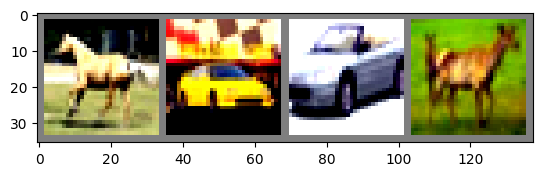

horse automobile automobile deer 


In [14]:
# get some random training images
batch_size=4
dataiter = iter(train_loader)
classes = train_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


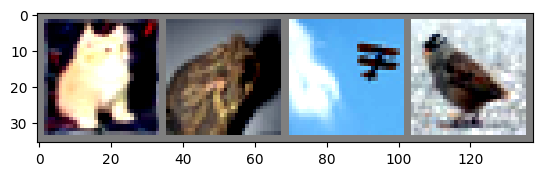

cat   frog  airplane bird 


In [15]:
# get some random testing images
batch_size=4
dataiter = iter(test_loader)
classes = test_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = NetLN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
       BatchNorm2d-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
         MaxPool2d-9            [-1, 8, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             128
        LayerNorm-11           [-1, 16, 16, 16]           8,192
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14           [-1

In [6]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [7]:
from torch.optim.lr_scheduler import StepLR
model =  NetLN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    # scheduler.step()
    test(model, device, test_loader, test_losses, test_acc)
    # scheduler.step(test_acc[-1])

EPOCH: 0


Loss=1.1272451877593994 Batch_id=390 Accuracy=45.38: 100%|██████████| 391/391 [00:06<00:00, 58.05it/s]



Test set: Average loss: 1.2245, Accuracy: 5576/10000 (55.76%)

EPOCH: 1


Loss=1.149693250656128 Batch_id=390 Accuracy=59.45: 100%|██████████| 391/391 [00:06<00:00, 59.34it/s] 



Test set: Average loss: 1.0705, Accuracy: 6179/10000 (61.79%)

EPOCH: 2


Loss=1.0644944906234741 Batch_id=390 Accuracy=64.85: 100%|██████████| 391/391 [00:06<00:00, 58.41it/s]



Test set: Average loss: 1.0150, Accuracy: 6343/10000 (63.43%)

EPOCH: 3


Loss=0.763192892074585 Batch_id=390 Accuracy=68.14: 100%|██████████| 391/391 [00:06<00:00, 58.68it/s] 



Test set: Average loss: 0.8967, Accuracy: 6817/10000 (68.17%)

EPOCH: 4


Loss=0.8100376129150391 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [00:06<00:00, 58.36it/s]



Test set: Average loss: 0.8432, Accuracy: 6989/10000 (69.89%)

EPOCH: 5


Loss=0.8532134890556335 Batch_id=390 Accuracy=72.34: 100%|██████████| 391/391 [00:06<00:00, 59.05it/s]



Test set: Average loss: 0.8035, Accuracy: 7155/10000 (71.55%)

EPOCH: 6


Loss=0.8738383054733276 Batch_id=390 Accuracy=73.76: 100%|██████████| 391/391 [00:06<00:00, 58.32it/s] 



Test set: Average loss: 0.8416, Accuracy: 7088/10000 (70.88%)

EPOCH: 7


Loss=0.676406979560852 Batch_id=390 Accuracy=75.11: 100%|██████████| 391/391 [00:06<00:00, 59.05it/s]  



Test set: Average loss: 0.7761, Accuracy: 7287/10000 (72.87%)

EPOCH: 8


Loss=0.7961804270744324 Batch_id=390 Accuracy=75.89: 100%|██████████| 391/391 [00:06<00:00, 58.35it/s]



Test set: Average loss: 0.7370, Accuracy: 7438/10000 (74.38%)

EPOCH: 9


Loss=0.7421563267707825 Batch_id=390 Accuracy=76.68: 100%|██████████| 391/391 [00:06<00:00, 58.84it/s] 



Test set: Average loss: 0.7264, Accuracy: 7473/10000 (74.73%)

EPOCH: 10


Loss=0.7823639512062073 Batch_id=390 Accuracy=77.46: 100%|██████████| 391/391 [00:06<00:00, 58.40it/s] 



Test set: Average loss: 0.7606, Accuracy: 7403/10000 (74.03%)

EPOCH: 11


Loss=0.6725308299064636 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:06<00:00, 58.64it/s] 



Test set: Average loss: 0.7471, Accuracy: 7426/10000 (74.26%)

EPOCH: 12


Loss=0.809543788433075 Batch_id=390 Accuracy=78.50: 100%|██████████| 391/391 [00:06<00:00, 58.71it/s]  



Test set: Average loss: 0.6945, Accuracy: 7595/10000 (75.95%)

EPOCH: 13


Loss=0.7817716002464294 Batch_id=390 Accuracy=79.22: 100%|██████████| 391/391 [00:06<00:00, 58.18it/s] 



Test set: Average loss: 0.7066, Accuracy: 7592/10000 (75.92%)

EPOCH: 14


Loss=0.6488515138626099 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [00:06<00:00, 58.46it/s] 



Test set: Average loss: 0.7385, Accuracy: 7491/10000 (74.91%)

EPOCH: 15


Loss=0.6799831390380859 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:06<00:00, 58.12it/s] 



Test set: Average loss: 0.6893, Accuracy: 7596/10000 (75.96%)

EPOCH: 16


Loss=0.6922225952148438 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [00:06<00:00, 58.51it/s] 



Test set: Average loss: 0.6986, Accuracy: 7603/10000 (76.03%)

EPOCH: 17


Loss=0.6056491136550903 Batch_id=390 Accuracy=80.82: 100%|██████████| 391/391 [00:06<00:00, 58.23it/s] 



Test set: Average loss: 0.7043, Accuracy: 7620/10000 (76.20%)

EPOCH: 18


Loss=0.6362000107765198 Batch_id=390 Accuracy=80.90: 100%|██████████| 391/391 [00:06<00:00, 58.45it/s] 



Test set: Average loss: 0.6655, Accuracy: 7733/10000 (77.33%)

EPOCH: 19


Loss=0.46492475271224976 Batch_id=390 Accuracy=81.53: 100%|██████████| 391/391 [00:06<00:00, 58.32it/s]



Test set: Average loss: 0.6653, Accuracy: 7683/10000 (76.83%)



In [8]:
misclassified = []
infer(model, device, infer_loader, misclassified)


In [9]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

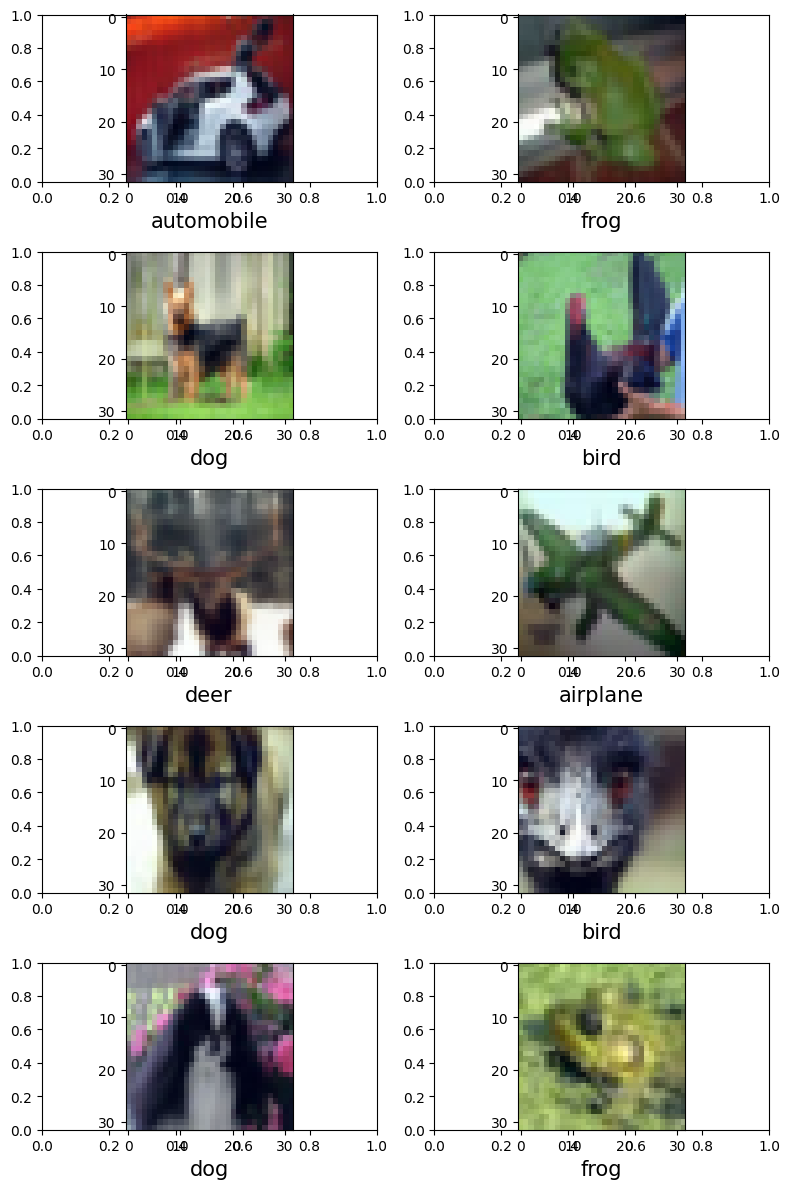

In [10]:
import matplotlib.pyplot as plt
samples = [infer_ds[idx][0] for idx in misclassified]
labels = [infer_ds[idx][1] for idx in misclassified]
# sample = interval_mapping(sample, np.min(sample), np.max(sample), 0, 255)
count = 0
f, axarr = plt.subplots(5,2, figsize=(8, 12))
for num in range(1, 11):
    f.add_subplot(5, 2, num)
    idx = num - 1
    img = samples[idx].numpy()
    img = interval_mapping(img, np.min(img), np.max(img), 0, 255)
    plt.imshow(np.transpose(img, (1, 2, 0)).astype(np.uint8))
    plt.xlabel(infer_ds.classes[labels[idx]], fontsize=15)

f.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

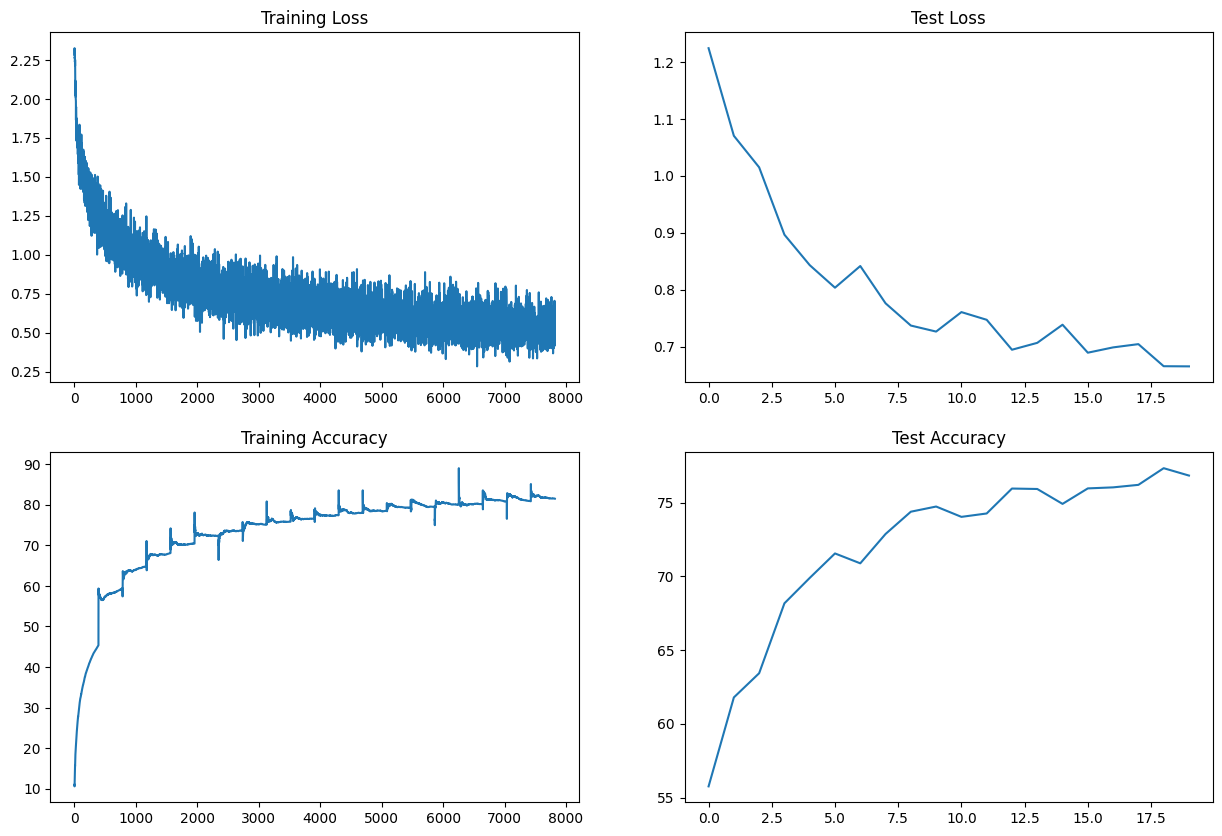

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")